## GPT ARCHITECTURE PART 7: Generating the next token


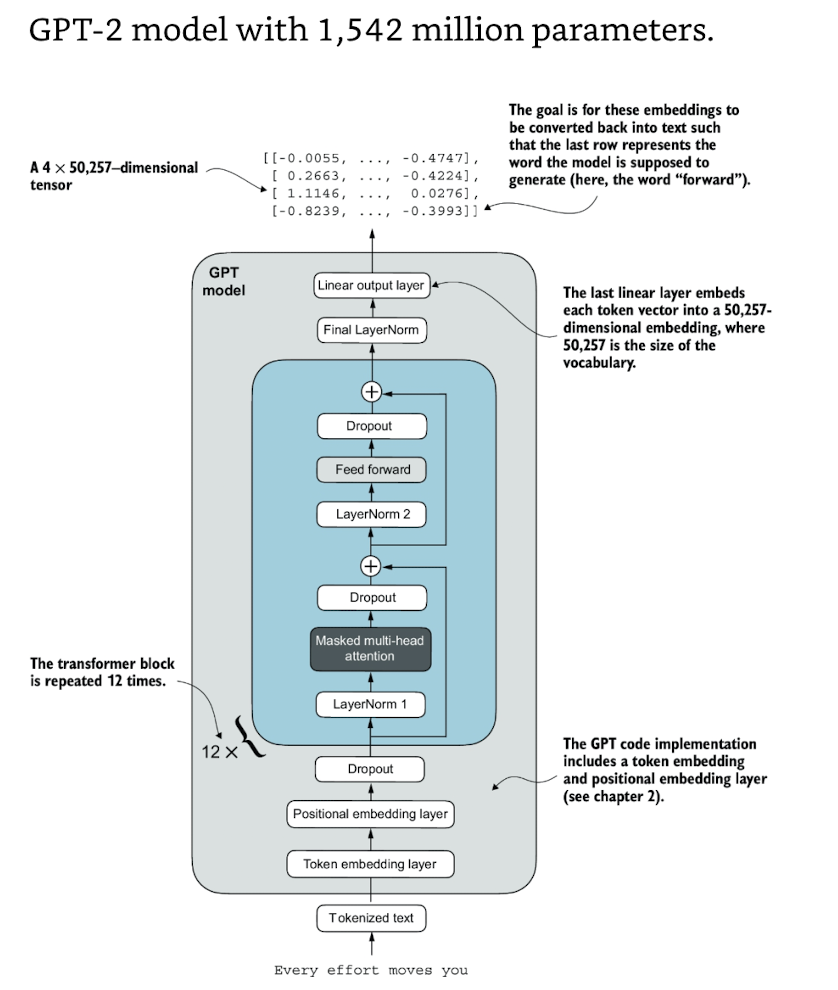


<div class="alert alert-block alert-info">

Visualizing the steps in the Architecture

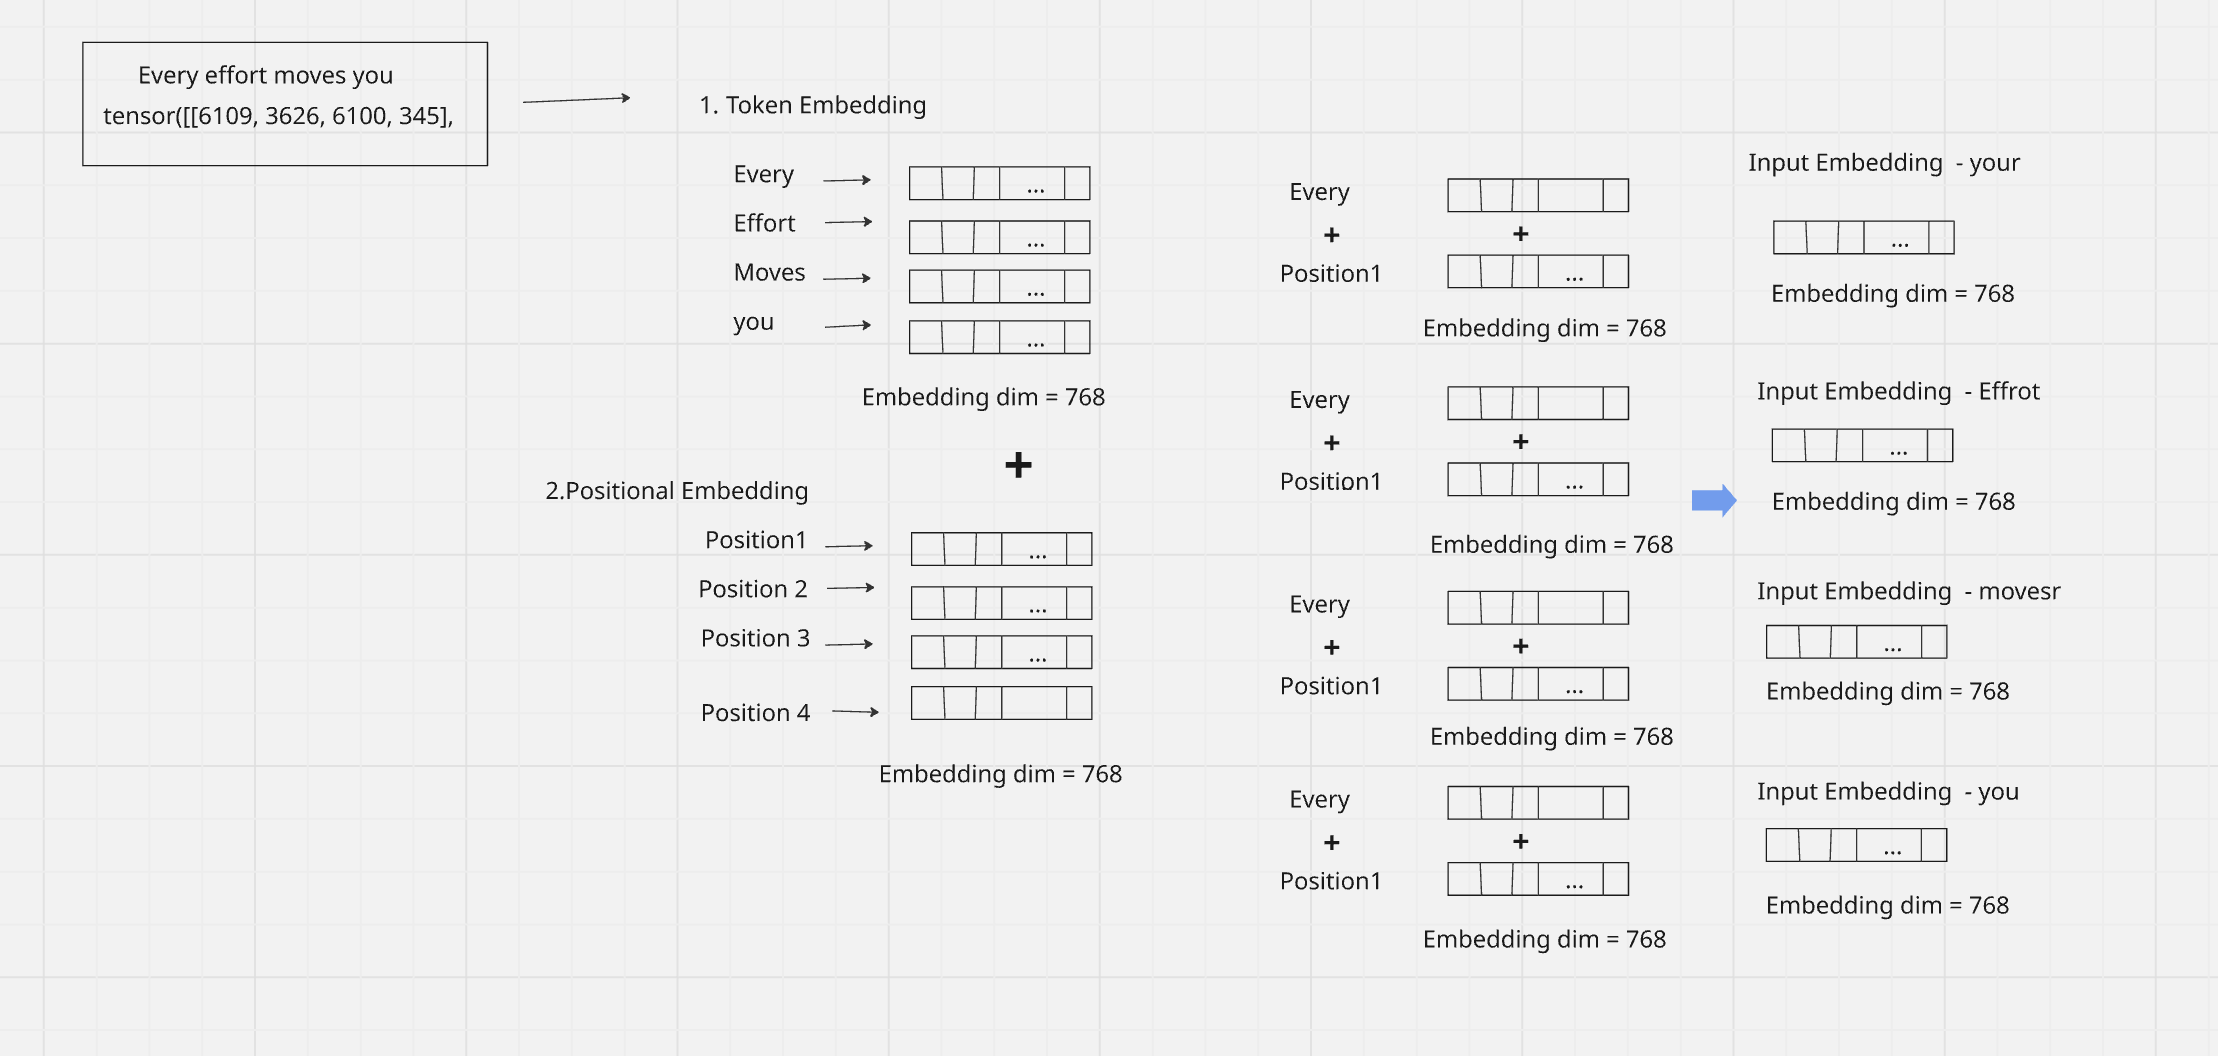

</div>

<div class="alert alert-block alert-info">

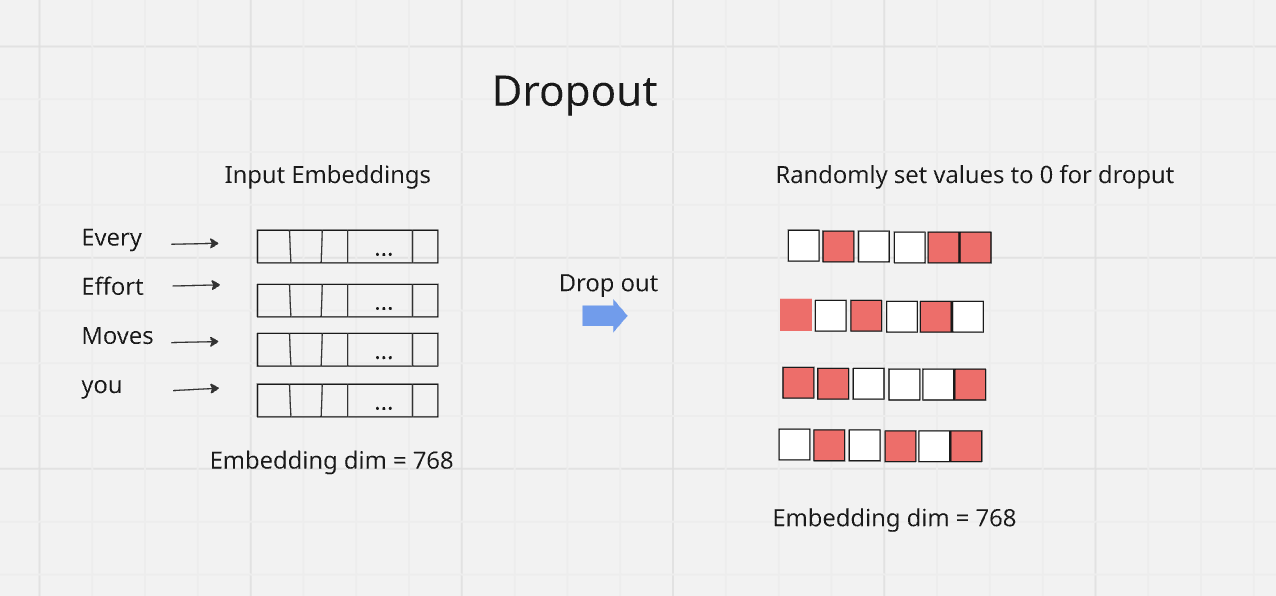

</div>

<div class="alert alert-block alert-info">
    
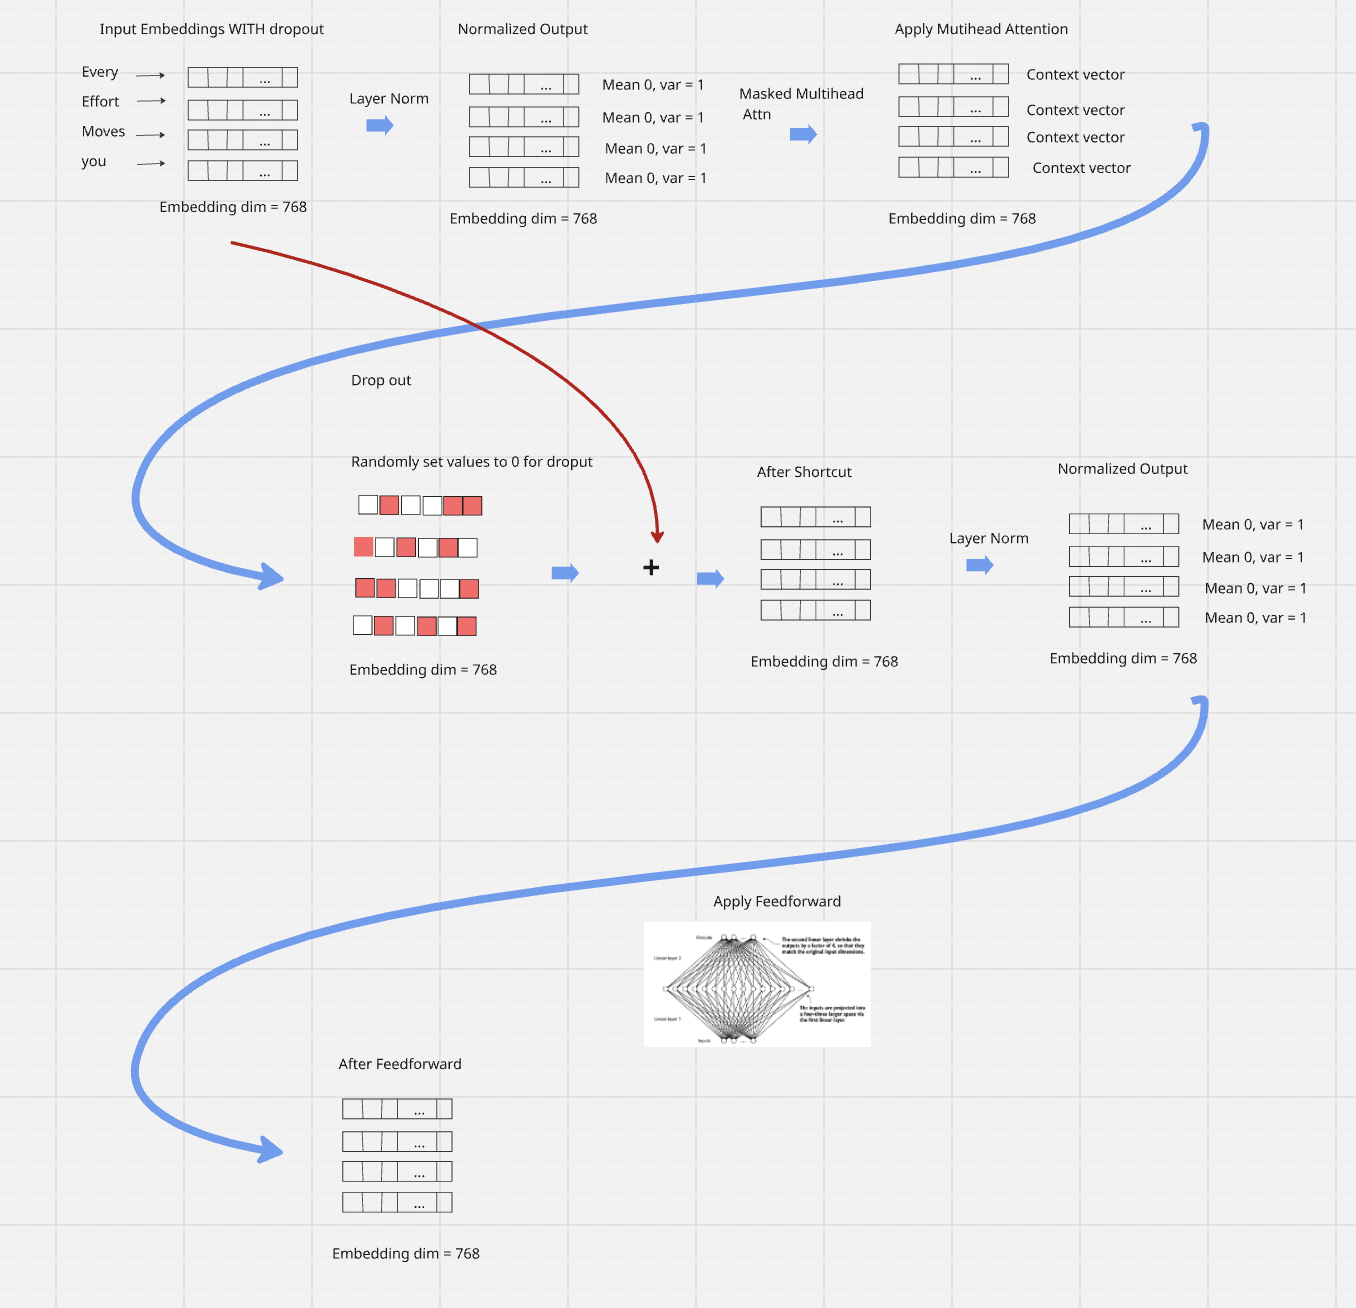

</div>

<div class="alert alert-block alert-info">

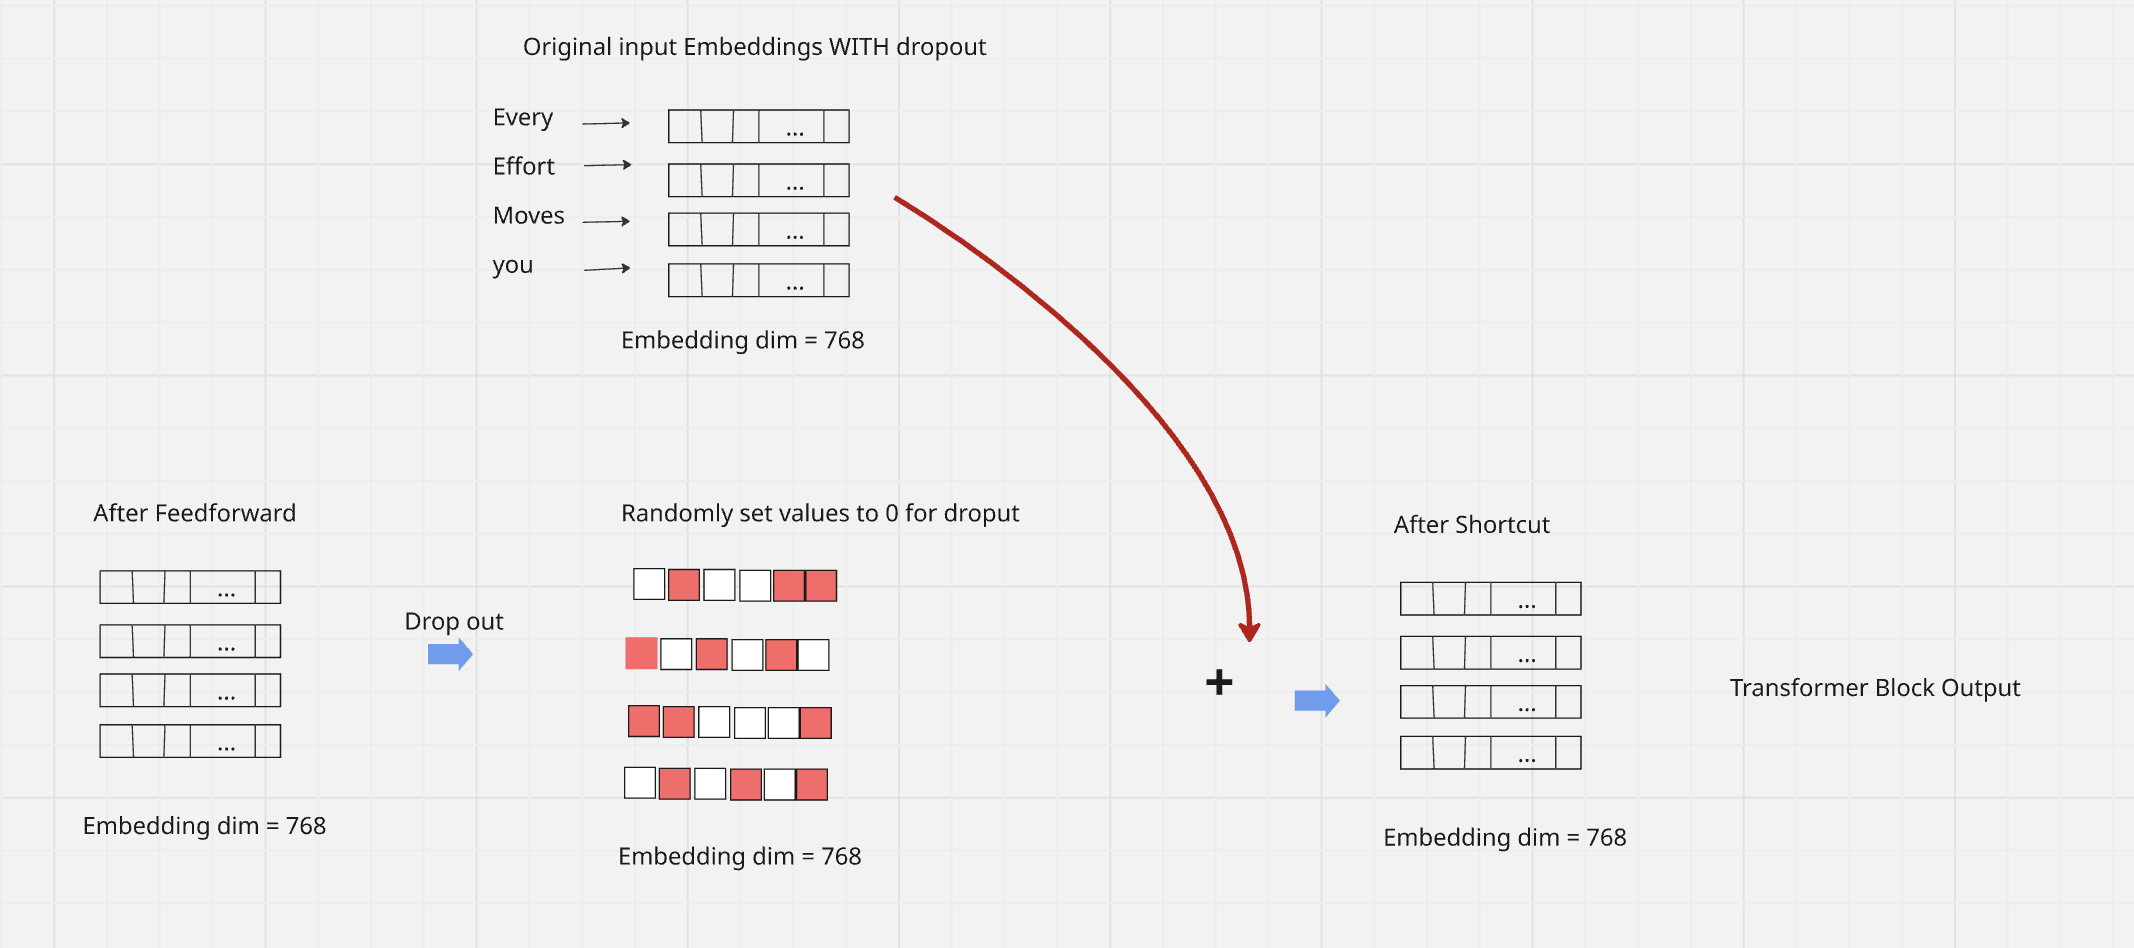

</div>


<div class="alert alert-block alert-info">

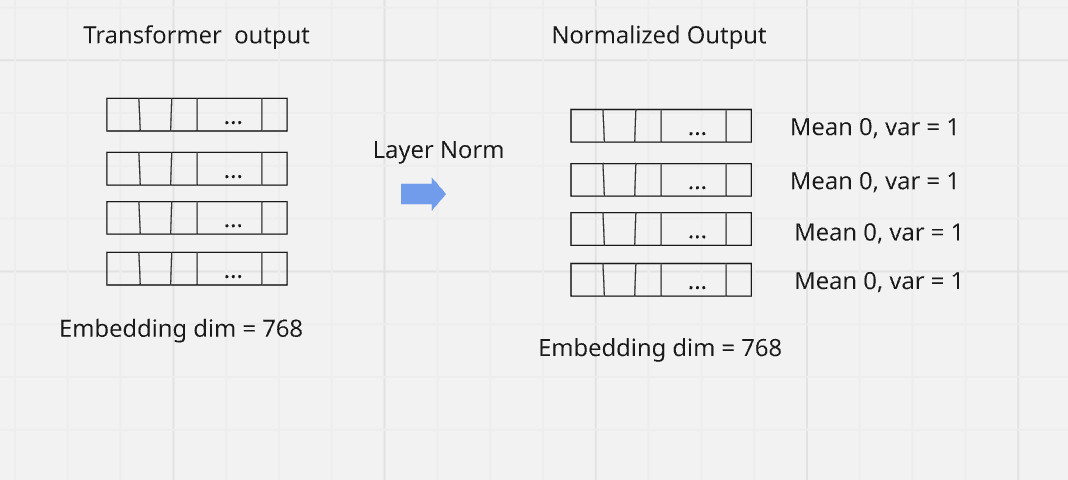

</div>

<div class="alert alert-block alert-info">

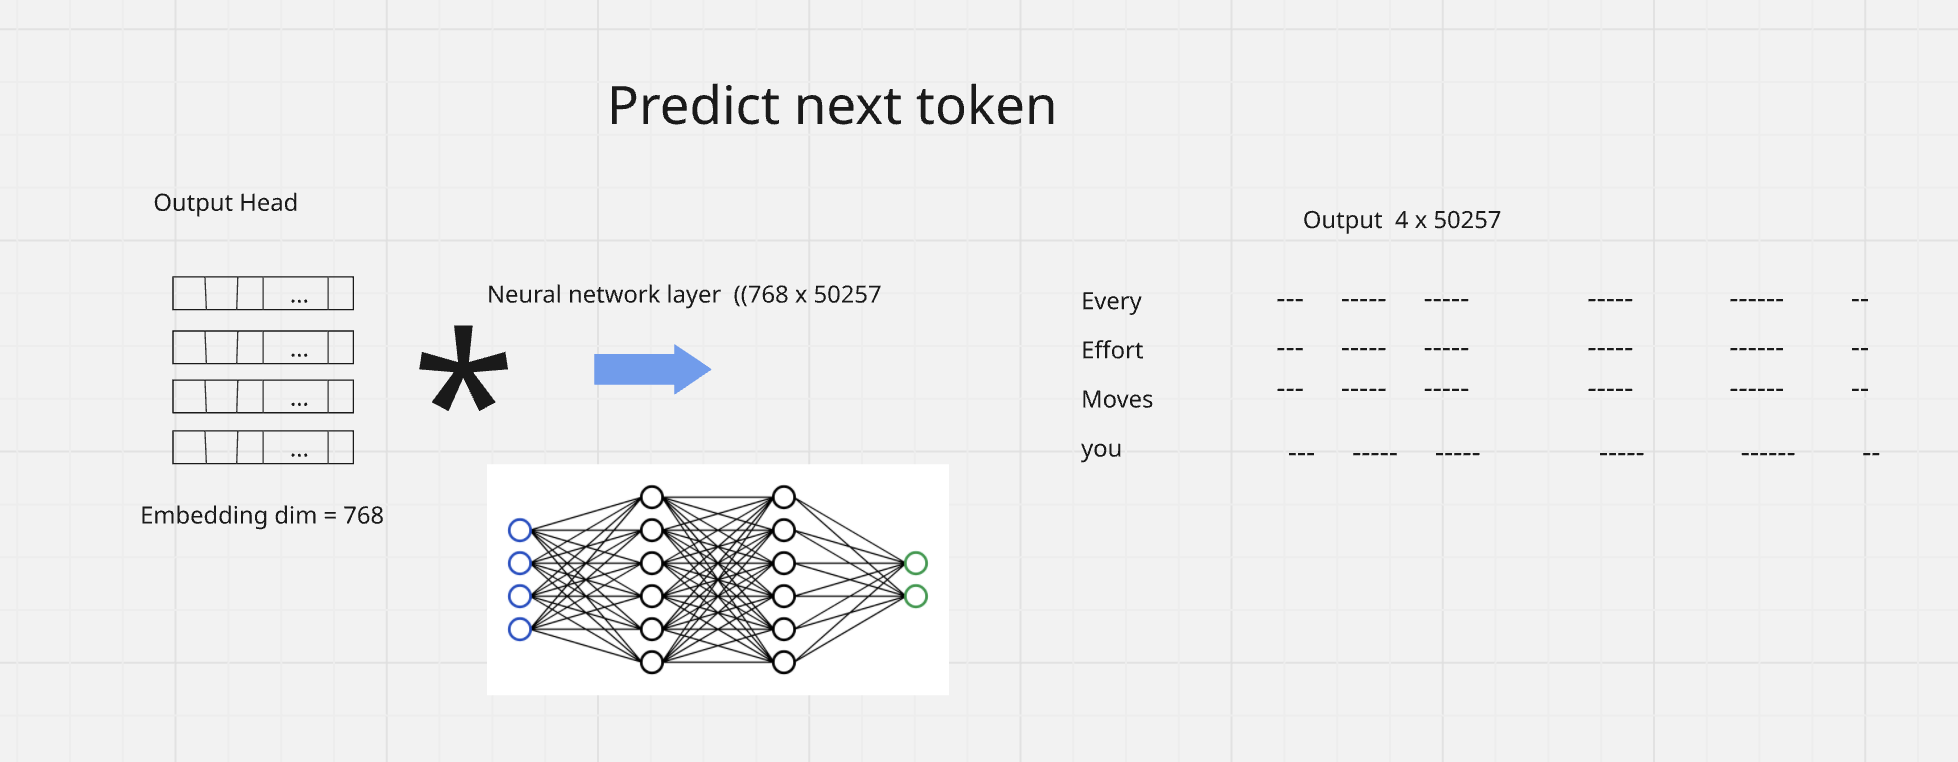

</div>

In [1]:
import torch
import torch.nn as nn

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size - tiktoken bpe
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [2]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [3]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [4]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size] #RETURNS CONTEXT
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [7]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

<div class="alert alert-block alert-warning">
    
The __init__ constructor of this GPTModel class initializes the token and positional
embedding layers using the configurations passed in via a Python dictionary, cfg. 

These
embedding layers are responsible for converting input token indices into dense vectors and
adding positional information.
</div>

<div class="alert alert-block alert-warning">
    
Next, the __init__ method creates a sequential stack of TransformerBlock modules
equal to the number of layers specified in cfg. 

Following the transformer blocks, a
LayerNorm layer is applied, standardizing the outputs from the transformer blocks to
stabilize the learning process. 

Finally, a linear output head without bias is defined, which
projects the transformer's output into the vocabulary space of the tokenizer to generate
logits for each token in the vocabulary.
</div>

<div class="alert alert-block alert-warning">
    
The forward method takes a batch of input token indices, computes their embeddings,
applies the positional embeddings, passes the sequence through the transformer blocks,
normalizes the final output, and then computes the logits, representing the next token's
unnormalized probabilities. We will convert these logits into tokens and text outputs in the
next section.
</div>

<div class="alert alert-block alert-success">
Let's now initialize the 124 million parameter GPT model using the GPT_CONFIG_124M
dictionary we pass into the cfg parameter and feed it with the batch text input we created
at the beginning of this chapter:
</div>

In [8]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [9]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


<div class="alert alert-block alert-info">

As we can see, the output tensor has the shape [2, 4, 50257], since we passed in 2 input
texts with 4 tokens each. The last dimension, 50,257, corresponds to the vocabulary size of
the tokenizer. In the next section, we will see how to convert each of these 50,257-
dimensional output vectors back into tokens.
    
</div>

<div class="alert alert-block alert-success">
Using the numel() method, short for "number of elements," we can collect the total
number of parameters in the model's parameter tensors:
</div>

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


<div class="alert alert-block alert-danger">
Earlier, we spoke of initializing a 124
million parameter GPT model, so why is the actual number of parameters 163 million, as
shown in the preceding code output?
</div>

<div class="alert alert-block alert-warning">
    
The reason is a concept called weight tying that is used in the original GPT-2
architecture, which means that the original GPT-2 architecture is reusing the weights from
the token embedding layer in its output layer. 

To understand what this means, let's take a
look at the shapes of the token embedding layer and linear output layer that we initialized
on the model via the GPTModel earlier:

</div>

In [11]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


<div class="alert alert-block alert-info">

As we can see based on the print outputs, the weight tensors for both these layers have the
same shape:
</div>

<div class="alert alert-block alert-success">
The token embedding and output layers are very large due to the number of rows for the
50,257 in the tokenizer's vocabulary. Let's remove the output layer parameter count from
the total GPT-2 model count according to the weight tying:
</div>

In [12]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


<div class="alert alert-block alert-info">

As we can see, the model is now only 124 million parameters large, matching the original
size of the GPT-2 model.
</div>

<div class="alert alert-block alert-warning">
    
Weight tying reduces the overall memory footprint and computational complexity of the
model. However, in my experience, using separate token embedding and output layers
results in better training and model performance; hence, we are using separate layers in
our GPTModel implementation. The same is true for modern LLMs.

</div>

<div class="alert alert-block alert-success">
Lastly, let us compute the memory requirements of the 163 million parameters in our
GPTModel object:
</div>

In [13]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


<div class="alert alert-block alert-warning">
    
In conclusion, by calculating the memory requirements for the 163 million parameters in
our GPTModel object and assuming each parameter is a 32-bit float taking up 4 bytes, we
find that the total size of the model amounts to 621.83 MB, illustrating the relatively large
storage capacity required to accommodate even relatively small LLMs.

</div>

<div class="alert alert-block alert-warning">
    
In this section, we implemented the GPTModel architecture and saw that it outputs
numeric tensors of shape [batch_size, num_tokens, vocab_size]. In the next section,
we will write the code to convert these output tensors into text.

</div>

<div class="alert alert-block alert-success">

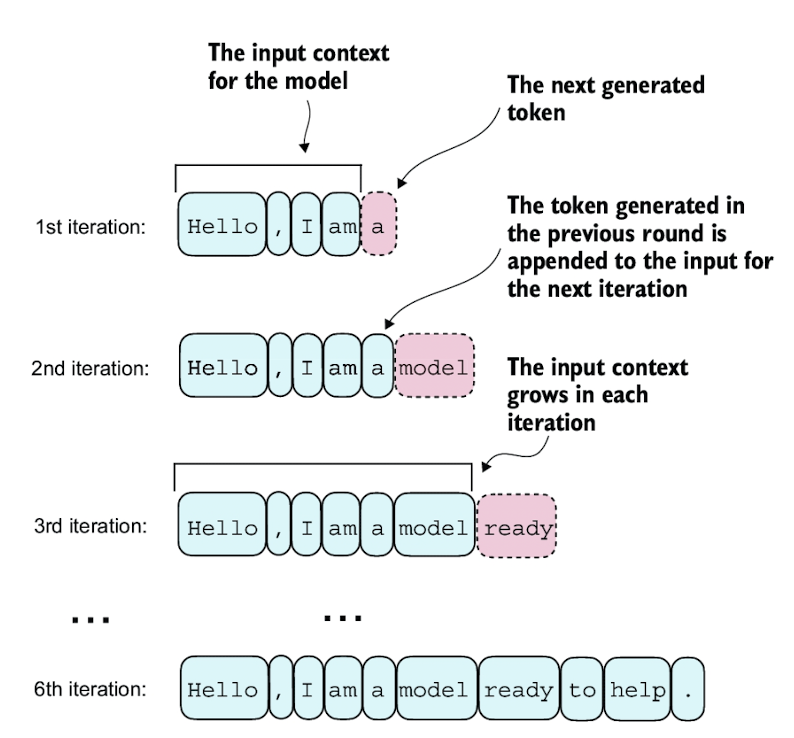

The step-by-step process by which an LLM generates text, one token at a time. Starting with an initial input context (“Hello, I am”), the model predicts a subsequent token during each iteration, appending it to the input context for the next round of prediction. As shown, the first iteration adds “a,” the second “model,” and the third “reaven a certain
A large language model operates by generating tokens based on a given sequence of input tokens. It predicts the next token in the sequence by analyzing the context, which is defined by the maximum number of tokens the model can consider before making its prediction.
We keep iterating until a predefined maximum number of new tokens has been generated. </br>
A key aspect of this process is the context size, which represents the maximum number of previous tokens the language model considers before predicting the next token. For example, in the GPT-2 architecture, the context size was 1,024 tokens. It's important to understand this iterative procedure, where the output from each iteration is appended to the input for the next iteration, enabling the model to predict the next word. This process continues until the predefined maximum number of new tokens has been generated.
</div>

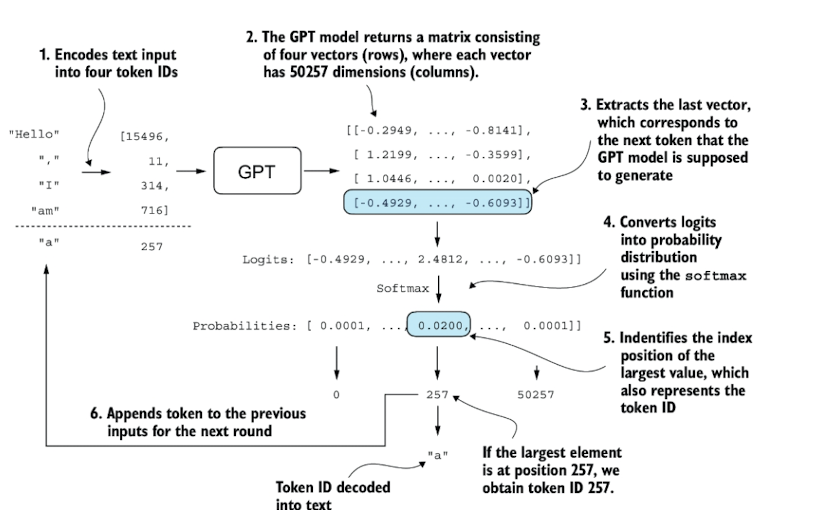

The mechanics of text generation in a GPT model by showing a single iteration in the token generation process. The process begins by encoding the input text into token IDs, which are then fed into the GPT model. The outputs of the model are then converted back into text and appended to the original input text.We repeat this process over multiple iterations until we generate the user-specified number of tokens. The process continues until the desired number of new tokens is reached, at which point it stops.


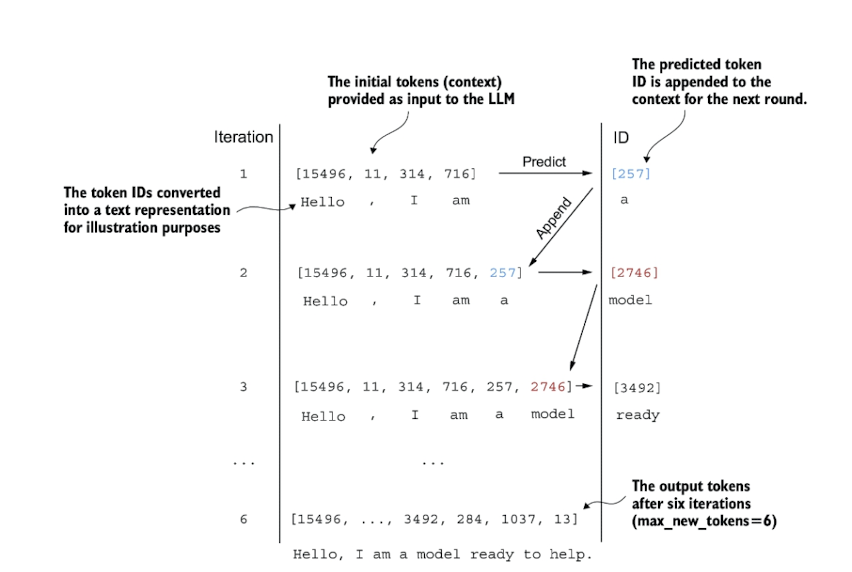

The six iterations of a token prediction cycle, where the model takes a sequence of initial token IDs as input, predicts the next token, and appends this token to the input sequence for the next iteration. (The token IDs are also translated into their corresponding text for better understanding.)


<div class="alert alert-block alert-success">
Let us implement the token-generation process as follows:
</div>

<div class="alert alert-block alert-info">

Step 1: idx is a (batch, n_tokens) array of indices in the current context

Step 2: Crop current context if it exceeds the supported context size E.g., if LLM supports only 5 tokens, and the
context size is 10 then only the last 5 tokens are used as context

Step 3: Focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)

Step 4: probas has shape (batch, vocab_size)

Step 5: idx_next has shape (batch, 1)

Step 6: Append sampled index to the running sequence, where idx has shape (batch, n_tokens+1)

</div>

In [14]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

<div class="alert alert-block alert-warning">
    
In the preceeding code, the generate_text_simple function, we use a softmax function to
convert the logits into a probability distribution from which we identify the position with the
highest value via torch.argmax. 

The softmax function is monotonic, meaning it preserves
the order of its inputs when transformed into outputs. 

So, in practice, the softmax step is
redundant since the position with the highest score in the softmax output tensor is the
same position in the logit tensor. 

In other words, we could apply the torch.argmax function
to the logits tensor directly and get identical results. 

However, we coded the conversion to
illustrate the full process of transforming logits to probabilities, which can add additional
intuition, such as that the model generates the most likely next token, which is known as
greedy decoding.

</div>

<div class="alert alert-block alert-warning">
    
In the next chapter, when we will implement the GPT training code, we will also
introduce additional sampling techniques where we modify the softmax outputs such that
the model doesn't always select the most likely token, which introduces variability and
creativity in the generated text.
</div>

<div class="alert alert-block alert-success">
Let's now try out the generate_text_simple function with the "Hello, I am" context
as model input
</div>

<div class="alert alert-block alert-success">
First, we encode the input context into token IDs:
</div>

In [15]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


<div class="alert alert-block alert-success">
Next, we put the model into .eval() mode, which disables random components like
dropout, which are only used during training, and use the generate_text_simple function
on the encoded input tensor:
</div>

<div class="alert alert-block alert-info">

We disable dropout since we are not training the model

</div>

In [16]:
model.eval() #A
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


<div class="alert alert-block alert-success">
Using the .decode method of the tokenizer, we can convert the IDs back into text:
</div>

In [17]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


<div class="alert alert-block alert-info">

As we can see, based on the preceding output, the model generated gibberish, which is not
at all coherent text. 

What happened? 

The reason why the model is unable to produce coherent text is that we haven't trained it yet. 

So far, we just
implemented the GPT architecture and initialized a GPT model instance with initial random
weights.

</div>